# Demo de modelos de Reservoir Computing (RC) para procesar imágenes e identificar la clase que corresponde

Librería: https://github.com/PlasmaControl/PyRCN

Documentación:  

https://www.sciencedirect.com/science/article/abs/pii/S0952197622001713

https://pyrcn.readthedocs.io/en/latest/?badge=latest

In [1]:
#@title Instalar PyRCN y actualiza SKLearn
!pip3 install -U scikit-learn
!pip3 install -U pyrcn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 3.6 MB/s eta 0:00:00


In [2]:
#@title Librerías a usar
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.utils import plot_model

import random

import keras.backend as K
from tensorflow.keras.preprocessing import image
import cv2
import copy

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import ipywidgets as widgets
from ipywidgets import Box, Layout

print("Librerías cargadas")

Librerías cargadas


##Imágenes:

In [3]:
#@title Acceder al Drive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demoML/imagenes/NUMEROS' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


> Para Entrenamiento: 
- Clases cargadas:  10
- Imágenes cargadas:  240
- Ejemplo  0   (32, 32, 3) : 


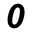



> Para Prueba: 
- Clases cargadas:  10
- Imágenes cargadas:  60
- Ejemplo  0   (32, 32, 3) : 


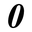

In [4]:
#@title Cargar imágenes

#@markdown ### Parámetros para imágenes:
imagen_ancho =  32#@param {type:"integer"}
imagen_largo =  32#@param {type:"integer"}
imagen_color = True #@param {type:"boolean"}

# tamaño de las imágenes
if imagen_ancho<=10:
  imagen_largo = 10
if imagen_largo<=10:
  imagen_largo = 10
IMAGE_SHAPE = (imagen_ancho, imagen_largo, (3 if imagen_color else 1))

# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = []
  images_ori = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:


            # abre la imagen
            imag = Image.open(auxiPath + "/" + each_imagFN)

            # ajusta el tamaño
            if IMAGE_SHAPE[2]==1:
              tipoImage = 'L'
            else:
              tipoImage = 'RGB'
            imag = imag.convert(tipoImage)
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.LANCZOS)

            # transforma a un vector de nros
            arImag = np.array(imag)

            # agrega a los vectores
            classes_ori.append( each_dir )
            images_ori.append( arImag )

  return classes_ori, images_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(np.unique(classes_train)))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(np.unique(classes_test)))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], tipoImage_test) )

In [5]:
#@title Ajustar imágenes para reducir el fondo (opcional)

accion_realizar = "-" #@param ["-", "Blur Fondo", "Eliminar Fondo y pasar a Negro", "Eliminar Fondo y pasar a Blanco"]

def cambiarColorNegro(img, nuevoColor=[255, 255, 255]):
    black_pixels = np.where(
        (img[:, :, 0] == 0) &
        (img[:, :, 1] == 0) &
        (img[:, :, 2] == 0)
    )
    img[black_pixels] = nuevoColor
    return img

def blurFondoImagen(im):
  # Convert to the HSV color space
  hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(hsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # We need a to copy the mask 3 times to fit the frames
  maskthresh = np.repeat(maskthresh[:, :, np.newaxis], 3, axis=2)
  #  Create a blurred frame using Gaussian blur
  blurred_frame = cv2.GaussianBlur(im, (25, 25), 0)
  # Combine the original with the blurred frame based on mask
  return np.where(maskthresh == (255, 255, 255), im, blurred_frame)

def reducirFondoImagen(im):
  # aplica filtro Hue
  imhsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
  # aplica filtro Otsu threshold para obtener máscara
  ret, maskthresh = cv2.threshold(imhsv[:,:,0], 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
  # Genera la máscara negada
  maskthresh = 255 - maskthresh
  # aplica la máscara sobre la imagen
  imgfin = cv2.bitwise_and(im, im, mask = maskthresh)
  return imgfin

def procesarImgRedFondo(imgList):
  nList = []
  for im in imgList:
    if accion_realizar == "Blur Fondo":
      # hacer blur del fondo
      imn = blurFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Negro":
      # eliminar fondo y dejar negro
      imn = reducirFondoImagen(im)
    elif accion_realizar == "Eliminar Fondo y pasar a Blanco":
        # cambia fondo negro a casi negro
        # (para que no cambié después)
        imn = cambiarColorNegro(im, [0, 0, 1])
        # eliminar fondo
        imn = reducirFondoImagen(imn)
        # cambiar fondo a blanco
        imn = cambiarColorNegro(imn, [255, 255, 255])
    else:
      print("Acción no definida!")
      break
    nList.append( imn )
  return nList


# degermina si hace algo o no
if accion_realizar != "-":
  # aplica filtros para intentar reducir el fondo de la imagen
  # cambiando las imágenes disponibles
  images_train = procesarImgRedFondo(images_train)
  images_test = procesarImgRedFondo(images_test)

  if len(classes_train)>0:
    print("- Ejemplo Entrenamiento con fondo reducido ", classes_train[0], " ", images_train[0].shape, ": ")
    display( Image.fromarray(images_train[0], tipoImage_train) )

  if len(classes_test)>0:
    print("- Ejemplo Prueba con fondo reducido ", classes_test[0], " ", images_test[0].shape, ": ")
    display( Image.fromarray(images_test[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (240, 32, 32, 3)
 - y_trainEnc (cant):  240
 - y_train (cant):  240


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (60, 32, 32, 3)
 - y_testEnc (cant):  60
 - y_test (cant):  60


> Para Ambos: 
 - dictMapeo:  {'2': 0, '0': 1, '5': 2, '3': 3, '8': 4, '4': 5, '1': 6, '9': 7, '7': 8, '6': 9}
 - clases_map:  ['2', '0', '5', '3', '8', '4', '1', '9', '7', '6']

 - Imagen reconstruida de  0 ( 1  /  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] )


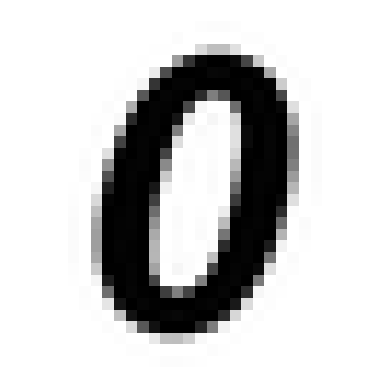

In [6]:
#@title Preparar imágenes para usar en el modelo

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8)) ## *255
    plt.gray()
  else:
    plt.imshow((imag).reshape(IMAGE_SHAPE).astype(np.uint8)) ## *255
  plt.axis("off")

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):
  auxiAr = np.array(imagList) ##.astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
  return auxiAr

# define función auxiliar para preparar lista de clases
def prepare_clasesList(classesList, dictMapeo=None):
  if dictMapeo==None:
    # genera diccionario de mapeo
    auxDict = list(set(classesList))
    dictMapeo = dict( zip( auxDict, range(len(auxDict)) ) )
  # realiza el mapeo
  y = []
  for cl in classesList:
      y.append( dictMapeo[cl] )
  # convierte valores numéricos a columnas de vakores binarios (i.e. one hot encoded)
  dummy_y = to_categorical(y)
  # devuelve
  return np.array(y), np.array(dummy_y), dictMapeo

# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train)
x_test = prepare_imageList(images_test)

# define vector auxiliar de datos de salida para usar en el entrenamiento y prueba
# también usa esta información para determinar la cantida de neuronas de salida
y_train, y_trainEnc, dictMapeo = prepare_clasesList(classes_train)
y_test, y_testEnc,_ = prepare_clasesList(classes_test, dictMapeo)

# genera diccionario auxiliar para poder convertir de ID de clase a nombre de clase
clases_map = [ x for x,y in dictMapeo.items() ]

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_trainEnc (cant): ", len(y_trainEnc))
print(" - y_train (cant): ", len(y_train))
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_testEnc (cant): ", len(y_testEnc))
print(" - y_test (cant): ", len(y_test))
print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", dictMapeo)
print(" - clases_map: ", clases_map)
if len(y_train)>0:
  print("\n - Imagen reconstruida de ", clases_map[y_train[0]],  "(", y_train[0], " / ", y_trainEnc[0], ")")
  plot_image(x_train[0])

##Modelo:

In [10]:
#@title Establecer modelo

import pyrcn.echo_state_network as esn
import pyrcn.extreme_learning_machine as elm

from pyrcn.base.blocks import BatchIntrinsicPlasticity
from sklearn.pipeline import Pipeline, FeatureUnion
from pyrcn.base.blocks import InputToNode, NodeToNode

from pyrcn.linear_model import IncrementalRegression
from sklearn.linear_model import Ridge as skRidge
from sklearn.linear_model import LinearRegression as skLinearRegression

from joblib import dump, load

# se asigna por compatibilidad
tipo_output_softMax = False

#@markdown ### Parámetros Generales:
tipoRCmodel = "Extreme Learning Machine" #@param ["Echo State Network", "Extreme Learning Machine"]
tipoRegressor = "skRidge" #@param ["Incremental Regression", "skLinearRegression", "skRidge"]
# define tipo regressor
tipoRegressorAux = str(tipoRegressor).lower()
if (tipoRegressorAux =="sklinearregression"):
  regressor = skLinearRegression()
elif (tipoRegressorAux =="skridge"):
  regressor = skRidge()
elif (tipoRegressorAux =="incremental regression"):
  regressor = IncrementalRegression()
else:
  regressor = None


#@markdown ### Parámetros de Capas:
input_hidden_layer_size = 50 #@param {type:"integer"}
input_activation = "identity" #@param ["identity", "tanh", "logistic", "relu"]
reservoir_activation = "tanh" #@param ["identity", "tanh", "logistic", "relu"]
recurrent_weights_per_node = 10 #@param {type:"integer"}


# define parametos iniciales
initially_fixed_params = {'hidden_layer_size': input_hidden_layer_size,
                          'input_activation': input_activation,
                          'bias_scaling': 0.0,
                          'reservoir_activation': reservoir_activation,
                          'leakage': 1.0,
                          'bidirectional': False,
                          'k_rec': recurrent_weights_per_node,
                          'spectral_radius': 0.9,
                          'leakage': 1.0,
                          'alpha': 1e-5,
                          'random_state': 42,
                          'requires_sequence': False}


# define tipo modelo RC
tipoModeloAux = str(tipoRCmodel).lower()
pyrcnModel = None
if (tipoModeloAux =="esn") or (tipoModeloAux =="echo state network"):
  # Echo State Network
  # modelo para clasificación
  pyrcnModel = esn.ESNClassifier(regressor=regressor,
                                **initially_fixed_params)


elif (tipoModeloAux =="elm") or (tipoModeloAux =="extreme learning machine"):
  # Extreme Learning Machine
  # modelo para clasificación
  pyrcnModel = elm.ELMClassifier(regressor=regressor,
                                **initially_fixed_params)
else:
  # Otro
  raise Exception("Tipo modelo " + str(tipoRCmodel) + " no soportado!")

# define clase auxiliar wapper
class pyrcnWrapper(object):

    def __init__(self, pyrcnModel, cantAtributosEntrada):
      self._modelo = pyrcnModel
      self._cantInputAtt = cantAtributosEntrada


    def display(self):
      print("\n", self._modelo,"\n")
      display(self._modelo)

    def fit(self, x, y):
      return self._modelo.fit(
                    X=x.reshape(-1, self._cantInputAtt),
                    y=y)

    def predict(self, x, verbose=0):
      y_pred = self._modelo.predict(x.reshape(-1, self._cantInputAtt))
      if len(y_pred)>0:
        return y_pred.reshape(-1, 1)
      else:
        return y_pred


model = pyrcnWrapper(pyrcnModel, IMAGE_SHAPE[0]*IMAGE_SHAPE[1]*IMAGE_SHAPE[2])

print("Modelo " + tipoRCmodel + " creado:")
model.display()


Modelo Extreme Learning Machine creado:

 ELMClassifier(input_to_node=InputToNode(bias_scaling=0.0, hidden_layer_size=50,
                                        input_activation='identity'),
              regressor=Ridge(alpha=1e-05, random_state=42)) 



ELMClassifier(input_to_node=InputToNode(bias_scaling=0.0, hidden_layer_size=50,
                                        input_activation='identity'),
              regressor=Ridge(alpha=1e-05, random_state=42))

In [11]:
#@title Entrenar

# entrena
print("\n\n>Comienza el Entrenamiento:")

model.fit(x_train, y_train)

print("\n>Entrenamiento Finalizado.")




>Comienza el Entrenamiento:

>Entrenamiento Finalizado.


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator.

In [12]:
#@title Evaluar red entrenada con datos de entrenamiento


# explicación y fuente de GradCAM en:
#   https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759
def prepareGradCAM(model, last_conv_layer_name):
  # genera sub-modelo desde capa de entrada a última capa convultional
  last_conv_layer = model.get_layer(last_conv_layer_name)
  subModel = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  return subModel

def aplicarGradCAM(subModel, last_conv_layer_shape, imgOrig, intensity=0.5, res=250):
  # prepara la imagen a procesar
  img = copy.deepcopy(imgOrig)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  # genera el heatmap
  with tf.GradientTape() as tape:
    model_out, last_conv_layer = subModel(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape(last_conv_layer_shape) # (8, 8))
  # aplica el heatmap
  imgHM = copy.deepcopy(imgOrig)
  heatmap = cv2.resize(heatmap, (imgHM.shape[1], imgHM.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  imgHM = heatmap * intensity + imgHM
  # devuelve imagen con HeatMap
  return imgHM

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, clases_map, tipo_output_softMax, umbralClas=50.0, mostrarGradCAM=False, rtdo="TODOS", cantMostrar="TODAS", claseFiltrar=None):

    # determina clase a filtrar
    if (claseFiltrar is None) or (claseFiltrar == "-"):
          clFiltrarID = None
          mostrarImagenes = False
    elif (claseFiltrar == "TODOS"):
          clFiltrarID = None
          mostrarImagenes = True
    else:
          clFiltrarID = dictMapeo[claseFiltrar]
          mostrarImagenes = True
    if umbralClas <= 0.0:
      umbralClas = 0.1
    elif umbralClas >= 100.0:
      umbralClas = 99.0
    else:
      umbralClas = umbralClas/100.0

    # determina tipo de resultado a mostrar
    if rtdo == "Clasificación Incorrecta":
      tipoRes = -1
    elif rtdo == "Clasificación Correcta":
      tipoRes = 1
    else:
      tipoRes = 0

    if mostrarGradCAM:
      # genera submodelo
      subModel = prepareGradCAM(model, last_conv_layer_name)
      # si muestra GradCAM también muestra imagen original
      mostrarImagenes = True

    # determina cantidad a mostrar
    if (cantMostrar == "TODAS"):
      cantMostrar = len(x)
    elif (cantMostrar <= 0):
      cantMostrar = 0
      mostrarImagenes = False

    # procesa las imágenes de prueba con el modelo
    predClass = model.predict(x, verbose=0)

    # lista auxiliar para mostrar
    imgsParaMostrar = []

    # muestra los resultados con las imágenes
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # asigna el nombre de la clase real
        clReal = clases_map[ y[i] ]

        # determina la clase predecida
        if tipo_output_softMax:
            ## determina clase predecida de acuerdo a la que tiene mayor valor
            idclPred = int( np.argmax(predClass[i], axis=0) )
            idclPredRnd = idclPred
        else:
            ## determina clase predecida de acuerdo al umbral de clasificación
            idclPred = predClass[i][0]
            idclPredRnd = int(idclPred)
            if (idclPred - idclPredRnd)>umbralClas and (idclPredRnd+1)<len(clases_map):
                  idclPredRnd = idclPredRnd + 1

        # asigna el nombre de la clase predecida
        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE INVÁLIDA"
        else:
            clPred = clases_map[ idclPredRnd ]

        # agrega a vevtores auxiliares
        classReal.append( clReal )
        classPreds.append( clPred )
        resClasOK = (clReal==clPred)

        if mostrarImagenes:

          # determina si filtra por clase
          if (clFiltrarID is None) or (clFiltrarID == y[i]):

            # filtra por tipo de resultado
            if (tipoRes==0) or \
              ((tipoRes > 0) and resClasOK) or\
              ((tipoRes < 0) and not(resClasOK)):
                # el titulo par aponer en la imagen
                strTitulo = 'Real: ' + str(clReal) + ' / Modelo: ' + str(clPred)
                if not resClasOK:
                  strTitulo = strTitulo + "!"
                #strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'

                # agrega para mostrar
                imgsParaMostrar.append( [strTitulo, x[i] ] )


    # cierra la imagen
    if mostrarImagenes and (cantMostrar>0) and (len(imgsParaMostrar)>0):
      print("\n>Detalle: ")

      if cantMostrar >= len(imgsParaMostrar):
        # muestra todas
        eligeImAlAzar = False
        cantMostrar = len(imgsParaMostrar)
      else:
        # muestra al azar
        eligeImAlAzar = True

      # prepara para mostrar imagenes
      if mostrarGradCAM:
        nCols = 2
        nRows = cantMostrar
        plt.figure(figsize=(5, 3*nRows))
      else:
        nCols = 3
        nRows = cantMostrar // nCols
        if (nRows*nCols) < cantMostrar:
          nRows = nRows + 1
        plt.figure(figsize=(10, 3*nRows))
      posImagen = 1

      for i in range(cantMostrar):
            # elige al azar o no para mostrar
            if eligeImAlAzar:
              posIm = random.randint(1, len(imgsParaMostrar))-1
            else:
              if i >= len(imgsParaMostrar):
                break
              else:
                posIm = i
            # determina datos a mostrar
            im = imgsParaMostrar[posIm][1]
            tit = imgsParaMostrar[posIm][0]

            # muestra la imagen
            ax = plt.subplot(nRows, nCols, posImagen)
            plot_image( im )
            plt.title( tit, fontsize=9 )
            posImagen = posImagen + 1

            # muestra resultado aplicar GRADCAM
            if mostrarGradCAM:
              imgGradCAM = aplicarGradCAM(subModel, last_conv_layer_shape, im)
              ax = plt.subplot(nRows, nCols, posImagen)
              plot_image( imgGradCAM )
              posImagen = posImagen + 1

            # saca elemento de la lista para no elegirlo al azar de nuevo
            if eligeImAlAzar:
              if len(imgsParaMostrar) > posIm:
                imgsParaMostrar.pop( posIm )

      #plt.tight_layout()
      fig = plt.gcf()
      plt.show()
      plt.close(fig)

    # genera lista de labels
    labels_clases_map =  list(set(classReal + classPreds))
    labels_clases_map.sort()

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))

    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=labels_clases_map)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in labels_clases_map],
        columns=['m:{:}'.format(x) for x in labels_clases_map]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    #cmtx.sort_index(axis=0, inplace=True)
    #cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")

    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=labels_clases_map)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()


# genera toda la interface para evaluar modeo DAE
def crearUI_evaluarModelo(clDefecto, clases, ruidoPorDefecto, funcionCambiaSeleccion):

  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}
  childrenList = []

  slider_umbral = widgets.FloatSlider(
      value=50,
      min=0,
      max=100.0,
      step=1.0,
      description='Umbral de Clasificación: ',
      disabled=False,
      continuous_update=False,
      orientation='horizontal',
      readout=True,
      style=style_3D,
      readout_format='.1f',
  )
  if not tipo_output_softMax:
    childrenList.append( slider_umbral )

  # prepara combo para filtrar por clase
  seleccion_CLASES = ["-", "TODOS"]
  seleccion_CLASES.extend( clases )
  seleccion_CLASES.sort()
  combo_clase = widgets.Dropdown(
      options = seleccion_CLASES,
      value = clDefecto,
      description = 'Filtrar por clase:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_clase )

  # prepara combo para filtrar por resultado
  selecc_resutado = [ "TODOS", "Clasificación Incorrecta", "Clasificación Correcta" ]
  combo_resultado = widgets.Dropdown(
      options = selecc_resutado,
      value = selecc_resutado[0],
      description = 'Filtrar por resultado:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_resultado )

  # prepara combo para filtrar por cantidad
  selecc_cantidad = [ 3 ]
  selecc_cantidad.extend( range(6, 151, 9) )
  selecc_cantidad.append( "TODAS" )
  combo_cantidad = widgets.Dropdown(
      options = selecc_cantidad,
      value = 6,
      description = 'Mostrar N imágenes al azar:',
      style=style_3D,
      disabled = False,
  )
  childrenList.append( combo_cantidad )

  mostrar_HeatMap_de_GradCAM = widgets.Checkbox(
        value=False,
        description='Mostrar HeatMap de GradCAM',
        disabled=False, visible=False
    )
  #childrenList.append( mostrar_HeatMap_de_GradCAM )


  prueba_ui = widgets.GridBox(children=childrenList,
          layout=Layout(width='100%')
        )
  out_prueba = widgets.interactive_output(funcionCambiaSeleccion, {'cant':combo_cantidad, 'rtdo': combo_resultado,'cl':combo_clase, 'h':mostrar_HeatMap_de_GradCAM, 'umbralClas':slider_umbral})

  return prueba_ui, out_prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cant, rtdo, cl, h, umbralClas):

    # prueba con los datos de entrenamiento
    print("\n\n*** Resultados con datos de Entrenamiento: ")
    probarModelo(x_train, y_train, clases_map, tipo_output_softMax, umbralClas, h, rtdo, cant, cl)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModelo( "-", clases_map, 0.0, cambiaSeleccion_clase_evaluar_imEntrenamiento)
display(ev_entrenamiento_ui, ev_entrenamiento_out)


GridBox(children=(FloatSlider(value=50.0, continuous_update=False, description='Umbral de Clasificación: ', re…

Output()

In [13]:
#@title Evaluar red entrenada con datos de prueba

# función para filtrar por clase
def cambiaSeleccion_clase_evaluar_imEntrenamiento(cant, rtdo, cl, h, umbralClas):

  # prueba con los datos de prueba
  print("\n\n*** Resultados con datos de Prueba: ")
  probarModelo(x_test, y_test, clases_map, tipo_output_softMax, umbralClas, h, rtdo, cant, cl)

# muestra la interface
ev_entrenamiento_ui, ev_entrenamiento_out = crearUI_evaluarModelo( "-", clases_map, 0.0, cambiaSeleccion_clase_evaluar_imEntrenamiento)
display(ev_entrenamiento_ui, ev_entrenamiento_out)


GridBox(children=(FloatSlider(value=50.0, continuous_update=False, description='Umbral de Clasificación: ', re…

Output()

In [14]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/IA/demoML/modelos/ImagRC'  #@param {type:"string"}

if guardar_modelo:

    import joblib
    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_modelo = path_modelo + "/RC.joblib"
    joblib.dump(model, fn_modelo)
    print("\n-Modelo guardado en ", fn_modelo,"\n")

    if ("IMAGE_SHAPE" in locals()) and (IMAGE_SHAPE is not None):
      fn_imageShape = path_modelo+"/IMAGE_SHAPE.txt"
      with open(fn_imageShape, 'w') as f:
        for i in IMAGE_SHAPE:
          f.write(str(i)+"\n")
      print("\n-IMAGE_SHAPE para cargar las imágenes guardado en ", path_modelo,"\n")


    if ("clases_map" in locals()) and (clases_map is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(clases_map)):
          f.write(str(i)+":"+str(clases_map[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", path_modelo,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/ImagRC/RC.joblib 


-IMAGE_SHAPE para cargar las imágenes guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/ImagRC 


-CLASES_MAP para mostrar los resultados guardado en  /content/gdrive/MyDrive/IA/demoML/modelos/ImagRC 

